<a href="https://www.kaggle.com/code/robinwien/credit-card-customer-segmentation?scriptVersionId=196797794" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import warnings
warnings.filterwarnings('ignore')

/kaggle/input/ccdata/CC GENERAL.csv


Import required libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Enable inline plotting for Colab notebooks
%matplotlib inline

Load and inspect the dataset

In [3]:
# Load the dataset, create a copy to work on, and inspect the first few rows.

dataset = pd.read_csv("/kaggle/input/ccdata/CC GENERAL.csv")
df = dataset.copy()

# Display first 5 rows of the dataset
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


Check the dataset info

In [4]:
# Understand the structure of the dataset, checking for null values and data types of each column.

df.info()

# Check for missing values
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

Handle missing values

In [5]:
# Fill missing values in 'CREDIT_LIMIT' and 'MINIMUM_PAYMENTS' with their respective column means.

df["CREDIT_LIMIT"].fillna(df["CREDIT_LIMIT"].mean(), inplace=True)
df["MINIMUM_PAYMENTS"].fillna(df["MINIMUM_PAYMENTS"].mean(), inplace=True)

# Verify that there are no missing values left
df.isnull().sum()

CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

Drop 'CUST_ID' column

In [6]:
# Drop the customer ID column, as it is not relevant for clustering.

df.drop("CUST_ID", axis=1, inplace=True)

Define function for distribution visualization

In [7]:
# This function visualizes the distribution of a numerical column, 
# with lines representing the mean, min, and max values for easy analysis.

def disvis(column):
    mean_ = df[column].mean()
    min_ = df[column].min()
    max_ = df[column].max()
    
    plt.figure(figsize=(6, 4))
    sns.histplot(df[column], bins=10, kde=True)
    
    plt.axvline(mean_, color='r', linestyle='--', label=f'Mean: {mean_:.2f}')
    plt.axvline(min_, color='g', linestyle='--', label=f'Min: {min_}')
    plt.axvline(max_, color='b', linestyle='--', label=f'Max: {max_}')
    
    plt.title(f'{column} Distribution')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

Outlier detection using IQR and log transformation

In [8]:
# Detect and treat outliers using the Interquartile Range (IQR) method.
# Log transformation is applied to columns with outliers to reduce skewness.

numeric_df = df.select_dtypes(include='number')
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1

# Count outliers in each numeric column
count_out = numeric_df[(numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR))].count()
df_count_out = pd.DataFrame(count_out, columns=['count_out'])

# Filter only the columns with outliers
df_count_out = df_count_out[df_count_out["count_out"] != 0]

# Apply log transformation to reduce the impact of outliers
for i in df_count_out.index:
    df[i] = np.log(df[i] + 1)

Recheck for outliers after transformation

In [9]:
# After applying the log transformation, recheck for any remaining outliers.

numeric_df = df.select_dtypes(include='number')
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1

# Recount outliers
count_out = numeric_df[(numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR))].count()
df_count_out = pd.DataFrame(count_out, columns=['count_out'])
df_count_out

,count_out
BALANCE,132
BALANCE_FREQUENCY,1716
PURCHASES,0
ONEOFF_PURCHASES,0
INSTALLMENTS_PURCHASES,0
CASH_ADVANCE,0
PURCHASES_FREQUENCY,0
ONEOFF_PURCHASES_FREQUENCY,481
PURCHASES_INSTALLMENTS_FREQUENCY,0
CASH_ADVANCE_FREQUENCY,337


Elbow method for optimal cluster number

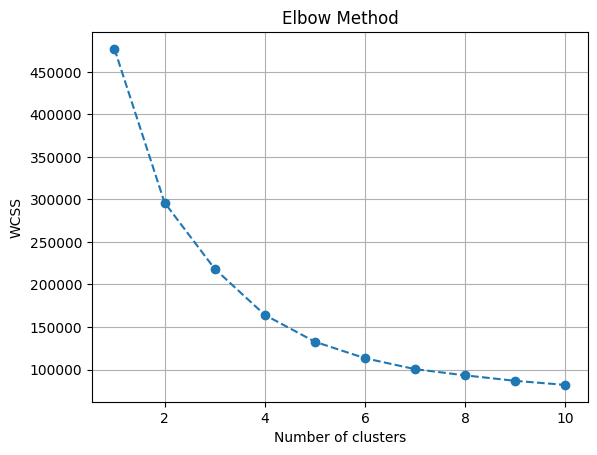

In [10]:
# Determine the optimal number of clusters using the Elbow method by plotting within-cluster sum of squares (WCSS).

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)

# Plot WCSS for each cluster count
plt.plot(range(1, 11), wcss, marker='o', linestyle="--")
plt.grid()
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Standardize the data and apply PCA

In [11]:
# Scale the data to standardize the feature values and then reduce dimensions using PCA for better visualization.

scaler = StandardScaler()
ndf = scaler.fit_transform(df)

# Perform PCA to reduce the dimensions to 2 components
pca = PCA(n_components=2)
df_pca = pca.fit_transform(ndf)

Apply KMeans clustering with 5 clusters

In [12]:
# Based on the Elbow method, apply KMeans with 5 clusters, and assign cluster labels.

kmeans = KMeans(n_clusters=5, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_pca)

# Add the PCA components for visualization
df['PCA1'] = df_pca[:, 0]
df['PCA2'] = df_pca[:, 1]

Visualize the clusters

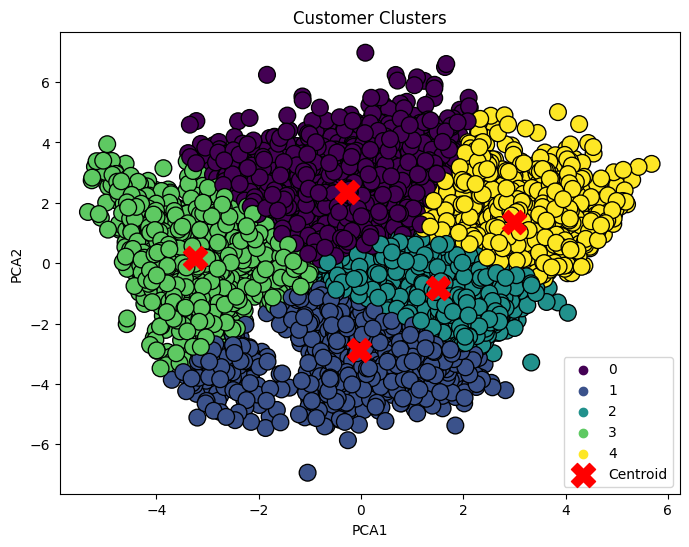

In [13]:
# Visualize the clusters in a 2D space using PCA components and show the centroids of each cluster.

centroids = df.groupby('Cluster').mean()[['PCA1', 'PCA2']].values

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df, palette='viridis', s=145, edgecolor='k')

# Plot the centroids
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='red', label='Centroid', marker='X')

plt.legend()
plt.title('Customer Clusters')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

Evaluate the clustering model's performance

In [14]:
# Evaluate the clustering model using Silhouette Score and Davies-Bouldin Score.

# Silhouette Score: Measures how similar an object is to its own cluster compared to other clusters.
silhouette_avg = silhouette_score(ndf, df['Cluster'])
print(f'Silhouette Score: {silhouette_avg:.3f}')

# Davies-Bouldin Score: Lower values indicate better clustering.
db_score = davies_bouldin_score(ndf, df['Cluster'])
print(f'Davies-Bouldin Score: {db_score:.3f}')

Silhouette Score: 0.187
Davies-Bouldin Score: 1.850
